Notebook to try various baseline upscaling estimates

In [54]:
## Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import dask.dataframe as dd
import dask_geopandas as dgpd
import statsmodels as sm
from statsmodels.formula.api import ols
from latlon_utils import get_climate, get_data_dir
import xarray as xr
import rioxarray


# import powerlaw

analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/'
roi_pth = '/mnt/f/PAD2019/classification_training/ROI-analysis/ROI-analysis_albers.shp'
useROI = True
roi_region = 'Baker' # PAD, Daring, YF

## Start with Kuhn 2021 regression equations from BAWLD-CH4.

### Try to replicate coefficients

In [257]:
## Load
df = pd.read_csv('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD-CH4/data/ek_out/archive/BAWLD_CH4_Aquatic.csv', 
    encoding = "ISO-8859-1", dtype={'CH4.E.FLUX ':'float'}, na_values='-')
len0 = len(df)

## Filter and pre-process
df.query("SEASON == 'Icefree' ", inplace=True) # and `D.METHOD` == 'CH'
df.dropna(subset=['SA', 'CH4.D.FLUX', 'TEMP'], inplace=True)

## if I want transformed y as its own var
df['CH4.D.FLUX.LOG'] = np.log10(df['CH4.D.FLUX']+1) 

## print filtering
len1 = len(df)
print(f'Filtered out {len0-len1} values ({len1} remaining).')
print(f'Variables: {df.columns}')

## View
df.head(2)

Filtered out 341 values (212 remaining).
Variables: Index(['ï»¿ID', 'NUM', 'STUDY', 'DATASET', 'YEAR', 'COUNTRY', 'SITE',
       'NUMBER.LAKES', 'LAT', 'LONG', 'ECOREGION', 'PERMA.ZONE', 'LAKE.TYPE',
       'BOTTOM', 'TALIK', 'SA', 'DEPTH', 'SEASON', 'YEAR.S', 'MONTH',
       'PATHWAY', 'D.METHOD', 'K600_EQ', 'K_REF', 'E.METHOD', 'E.LOCATION',
       'S.METHOD', 'D.DAYS', 'E.DAYS', 'LENGTH', 'CH4.D.FLUX', 'CH4.E.FLUX',
       'Seasonal.Diff.Flux', 'Seasonal.Ebul', 'Seasonal.Storage', 'IBS',
       'TEMP', 'DOC', 'PH', 'ICEFREE.DAYS', 'CLASS', 'SIZE', 'TYPE',
       'CD_Pcp_An', 'BIOME', 'GRID_T', 'NOTES', 'DOI', 'CH4.D.FLUX.LOG'],
      dtype='object')


,ï»¿ID,NUM,STUDY,DATASET,YEAR,COUNTRY,SITE,NUMBER.LAKES,LAT,LONG,...,ICEFREE.DAYS,CLASS,SIZE,TYPE,CD_Pcp_An,BIOME,GRID_T,NOTES,DOI,CH4.D.FLUX.LOG
4,5,2,Bastviken et al. 2004,WIK,2004,Sweden,Bisen,1.0,NaN,NaN,...,245.0,MLOP,M,OP,NaN,NaN,NaN,NaN,https://doi.org/10.1029/2004GB002238,0.230449
6,7,2,Bastviken et al. 2004,WIK,2004,Sweden,Grunnen,1.0,NaN,NaN,...,245.0,MLOP,M,OP,NaN,NaN,NaN,NaN,https://doi.org/10.1029/2004GB002238,0.623249


Text(0.5, 0, 'Mg CH4 / m2 /day')

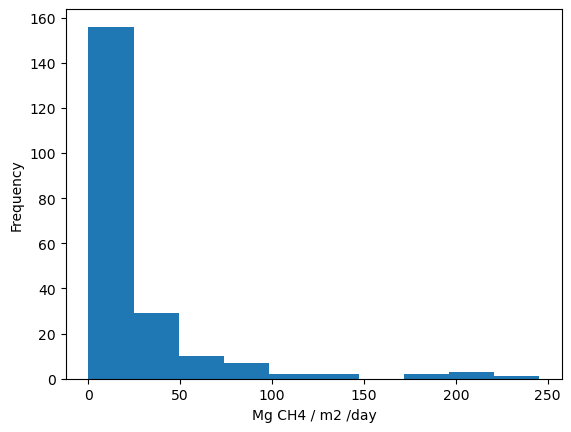

In [278]:
## Viz plot
df['CH4.D.FLUX'].plot.hist()
plt.xlabel('Mg CH4 / m2 /day')

In [322]:
## Linear models (regression)

formula = "np.log10(Q('CH4.D.FLUX')) ~ np.log10(SA) + TEMP" # 'Seasonal.Diff.Flux' 'CH4.D.FLUX'
model1 = ols(formula=formula, data=df).fit()
# print(f'R2: {model1.rsquared:0.3}')
model1.summary() # Their model uses 149 data points with adj r2 = 0.36

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     np.log10(Q('CH4.D.FLUX'))   R-squared:                       0.300
Model:                                   OLS   Adj. R-squared:                  0.293
Method:                        Least Squares   F-statistic:                     44.76
Date:                       Tue, 07 Feb 2023   Prob (F-statistic):           6.62e-17
Time:                               09:26:08   Log-Likelihood:                -146.11
No. Observations:                        212   AIC:                             298.2
Df Residuals:                            209   BIC:                             308.3
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0465      0.118      0.395      0.693      -0.185       0.278
np.log10(SA)    -0.1575      0.030     -5.298      0.000      -0.216      -0.099
TEMP             0.0555      0.008      6.608      0.000       0.039       0.072
==============================================================================
Omnibus:                        4.111   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                3.708
Skew:                          -0.289   Prob(JB):                        0.157
Kurtosis:                       3.293   Cond. No.                         50.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [323]:
## Pull out coeffs
model1.params

Intercept       0.046480
np.log10(SA)   -0.157475
TEMP            0.055498
dtype: float64

## Apply models

In [59]:
## Load ROI
if useROI:
    roi = gpd.read_file(roi_pth).query('Region == @roi_region')
    roi.crs = 'ESRI:102001' # only needed if loading UAVSAR 
    roi = roi.to_crs('EPSG:4326')
else:
    roi = None

In [78]:
## I/O This file is the output of QGIS join nearest and when there are multiple nearest BAWLD grid cells (didst 0) to a large lake, multiple rows are created.
## Loading is actually quicker w/o using a bounding box or mask!
# dfHL = pd.read_excel('/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.dbf', usecols=['Hylak_id', 'Shp_Area', 'BAWLDCell_']) # silly bc this shapefile contains duplicates and takes forever to load...
# gdfHL = gpd.read_file('/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp', usecols=['Hylak_id', 'Shp_Area', 'BAWLDCell_'],)
gdfHL = gpd.read_file('/mnt/g/Ch4/GSW_zonal_stats/HL/v3/WBD_jnBAWLD.shp', usecols=['OBJECTID', 'Area', 'BAWLDCell_'],)
    # mask = roi)
    # bbox = roi.total_bounds.tolist())
gdfHL_save = gdfHL


<AxesSubplot:>

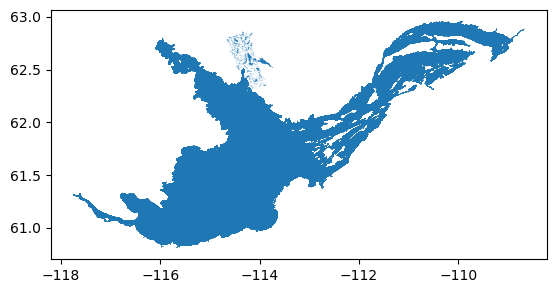

In [92]:
## Clip to ROI (note clip actually clips the geometries)
# gdfHL_clip = gdfHL.clip(roi)
gdfHL = gpd.sjoin(gdfHL, roi)
gdfHL.plot()

In [93]:
## Take only the first entry for each lake so join  becomes one-one
gdfHL = gdfHL.groupby('Hylak_id').first()

### Side Workflow: Testing with parquet speed

In [384]:
## Save as parquet
gdfHL = dgpd.read_file('/mnt/g/Ch4/GSW_zonal_stats/HL/v3/HL_zStats_Oc_binned_jnBAWLD.shp', columns=['Hylak_id', 'Shp_Area', 'BAWLDCell_', 'geometry'],
    chunksize=5000)

In [386]:
# gdfHL.clip(roi)
type(gdfHL)
# gdfHL.clip?
gdfHL.calculate_spatial_partitions()

In [389]:

dgpd_clip = dgpd.clip(gdfHL, roi)
dgpd_clip.compute()

/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. T

,BAWLDCell_,Hylak_id,Shp_Area,geometry
6383,8442,3948,38.66,"POLYGON ((-114.06058 62.58021, -114.06557 62.5..."
6384,8443,3948,38.66,"POLYGON ((-114.06058 62.58021, -114.06557 62.5..."
6394,8442,3956,36.52,"POLYGON ((-114.25825 62.66982, -114.25536 62.6..."
6338,8442,3917,24.75,"MULTIPOLYGON (((-114.20183 62.76192, -114.2011..."
546423,7907,558888,0.78,"POLYGON ((-114.13635 62.33231, -114.13660 62.3..."
...,...,...,...,...
57,7387,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."
104,7912,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."
102,7911,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."
97,8440,3,26734.29,"MULTIPOLYGON (((-114.34862 62.42650, -114.3476..."


In [392]:
dgpd_clip

,BAWLDCell_,Hylak_id,Shp_Area,geometry
npartitions=8,,,,
,int64,int64,float64,geometry
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [404]:
## Test write to parquet
parquet_out_pth = '/mnt/g/Ch4/GSW_zonal_stats/HL/v3/test/HL_zStats_Oc_binned_jnBAWLD_Baker_clip_parquet'
dgpd_clip.to_parquet(parquet_out_pth)
# dgpd_clip.to_parquet?

/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. T

In [405]:
## Test read parquet file
foo2 = dgpd.read_parquet([f'{parquet_out_pth}/part.{i}.parquet' for i in range(8)])
foo2


TypeError: An error occurred while calling the read_parquet method registered to the pandas backend.
Original Message: GeoArrowEngine._create_dd_meta() takes 2 positional arguments but 3 were given

### Join in climate data from WorldClim using pypi package latlon_utils 
(netcdf is in ~/.local/share/latlon_utils/)

In [94]:
## Join in BAWLD attributes
gdfBAWLD = gpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip')
gdfHL = gdfHL.merge(gdfBAWLD[['Cell_ID', 'Long', 'Lat']], left_on='BAWLDCell_', right_on='Cell_ID')

gdfHL.head(3)

,0-5,5-50,50-95,95-100,Class_sum,Shp_Area,BAWLDCell_,n,distance,feature_x,...,nearest_x,nearest_y,geometry,index_right,id,Region,Note,Cell_ID,Long,Lat
0,0.232737,0.198573,4.089538,95.479152,26893.426,26734.29,7387,1,0.0,-113.000000,...,-113.000000,61.500000,"POLYGON ((-109.93976 62.95851, -109.93831 62.9...",2,1,Baker,Baker - outermost,7387,-113.25,61.75
1,4.258225,4.744306,86.522316,4.475154,24.893,24.75,8442,1,0.0,-114.134654,...,-114.134654,62.852126,"POLYGON ((-114.13465 62.85213, -114.13516 62.8...",2,1,Baker,Baker - outermost,8442,-114.25,62.75
2,2.601877,2.470755,34.824528,60.102841,38.895,38.66,8442,1,0.0,-114.000000,...,-114.000000,62.576271,"POLYGON ((-113.95252 62.61332, -113.95139 62.6...",2,1,Baker,Baker - outermost,8442,-114.25,62.75


### Side workflow: Apply to BAWLD lakes to use as lookup table (don't need for main workflow)


#### Side workflow for gap-filling worldclim Temp netcdf so ocean cells take nearest land value

In [ ]:
## Verify NaNs in worldclim over oceans
get_climate(80.25, 16.25)

tavg  jan   NaN
      feb   NaN
      mar   NaN
      apr   NaN
      mai   NaN
      jun   NaN
      jul   NaN
      aug   NaN
      sep   NaN
      oct   NaN
      nov   NaN
      dec   NaN
      djf   NaN
      mam   NaN
      jja   NaN
      son   NaN
      ann   NaN
prec  jan   NaN
      feb   NaN
      mar   NaN
      apr   NaN
      mai   NaN
      jun   NaN
      jul   NaN
      aug   NaN
      sep   NaN
      oct   NaN
      nov   NaN
      dec   NaN
      djf   NaN
      mam   NaN
      jja   NaN
      son   NaN
      ann   NaN
Name: (80.25, 16.25), dtype: float64

In [109]:
## Load worldclim data
latlong_utils_data_dir = get_data_dir()
da = xr.load_dataset(os.path.join(latlong_utils_data_dir, 'tavg_10m.nc'))

## View
da

<xarray.Dataset>
Dimensions:  (lat: 1080, lon: 2160, month: 12)
Coordinates:
    band     int64 1
  * lat      (lat) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tavg     (month, lat, lon) float32 -inf -inf -inf ... -19.3 -19.28 -18.09

In [141]:
## Practice selecting with dask
da
# da.tavg[89.92, -179.9, 2]
# daa = xr.DataArray(da)
# da.tavg[3,0,0]
da.tavg.sel(lat=[89.92, 89.75], lon=[-179.9, -179.8], month=1, method='nearest')
# da.tavg.loc[0, 89.92, -179.9]

<xarray.DataArray 'tavg' (lat: 2, lon: 2)>
array([[-inf, -inf],
       [-inf, -inf]], dtype=float32)
Coordinates:
    band     int64 1
  * lat      (lat) float64 89.92 89.75
  * lon      (lon) float64 -179.9 -179.8
    month    int64 1
Attributes:
    transform:      [ 1.66666667e-01  0.00000000e+00 -1.80000000e+02  0.00000...
    crs:            +init=epsg:4326
    res:            [0.16666667 0.16666667]
    is_tiled:       0
    nodatavals:     -3.3999999521443642e+38
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area
    long_name:      maximum temperature
    units:          degC
    history:        2023-02-03T17:04:07.722449: Downloaded tavg data with lat...
    reference:      Fick, S.E. and R.J. Hijmans, 2017. Worldclim 2: New 1-km ...

I tried using xarray.DataSet.interpolate_na, but it only works in one dim... from scipy.interpolate import NearestNDInterpolator was too complicated

In [ ]:
## Convert -inf to nan to enable filling
ds_masked = da.where(da['tavg'] != -np.inf)

## Verify
ds_masked.tavg

<xarray.DataArray 'tavg' (month: 12, lat: 1080, lon: 2160)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-18.87976 , -19.53003 , -19.530762, ..., -21.501526,
         -21.49524 , -20.174744],
        [-16.98999 , -17.919983, -17.919983, ..., -19.73999 ,
         -19.732727, -18.200256],
        [-17.273499, -17.862488, -17.880005, ..., -19.684753,
         -19.672241, -18.494019]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-24.55603 , -25.22998 , -25.231262, ..., -27.825012,
         -27.812988, -26.461243],
        [-22.179016, -23.252502, -23.26001 , ..., -25.646729,
         -25.63324 , -23.947754],
        [-22.613281, -23.225525, -23.22998 , ..., -25.619995,
         -25.609741, -24.393982]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-18.36023 , -19.015015, -19.015259, ..., -21.083496,
         -21.067505, -19.755249],
        [-16.507263, -17.432007, -17.437256, ..., -19.330017,
         -19.327515, -17.807983],
        [-16.775513, -17.360779, -17.37378 , ..., -19.295471,
         -19.279724, -18.091003]]], dtype=float32)
Coordinates:
    band     int64 1
  * lat      (lat) float64 89.92 89.75 89.58 89.42 ... -89.58 -89.75 -89.92
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.4 ... 179.6 179.8 179.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    transform:      [ 1.66666667e-01  0.00000000e+00 -1.80000000e+02  0.00000...
    crs:            +init=epsg:4326
    res:            [0.16666667 0.16666667]
    is_tiled:       0
    nodatavals:     -3.3999999521443642e+38
    scales:         1.0
    offsets:        0.0
    AREA_OR_POINT:  Area
    long_name:      maximum temperature
    units:          degC
    history:        2023-02-03T17:04:07.722449: Downloaded tavg data with lat...
    reference:      Fick, S.E. and R.J. Hijmans, 2017. Worldclim 2: New 1-km ...

In [ ]:
## Fill nans using rio
ds_masked2 = ds_masked.tavg.rio.set_spatial_dims('lon','lat', inplace=False) # inplace doesn't work
ds_masked2.rio.write_nodata(np.nan, inplace=True)
filled = ds_masked2.rio.interpolate_na()

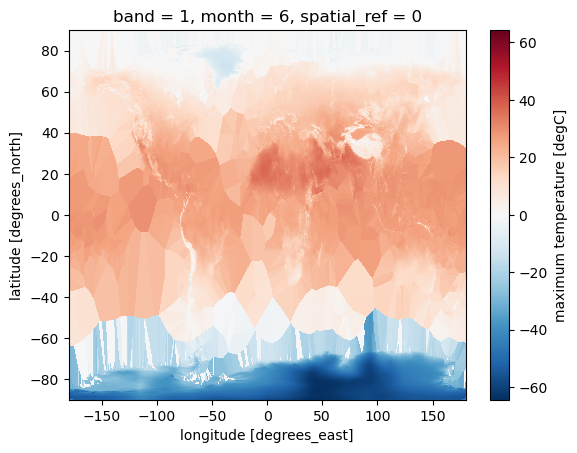

In [ ]:
## Save back to array
da['tavg'] = filled

## Plot
da.tavg.sel(month=6).plot.imshow()

## save
da.to_netcdf(os.path.join(latlong_utils_data_dir, 'tavg_10m_filled.nc'))

#### Apply to BAWLD lakes to use as lookup table (don't need for this workflow)


In [ ]:
## Load
dgdfBAWLD = dgpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip', chunksize=1000)


In [ ]:
## partitions
dgdfBAWLD.calculate_spatial_partitions()

In [ ]:
## Map function
BAWLD_clim = dgdfBAWLD.map_partitions(applyGet_climate).compute()


In [ ]:
## Join in BAWLD ID
BAWLD_clim_jn = pd.concat((BAWLD_clim.reset_index(), dgdfBAWLD['Cell_ID'].compute()), axis=1) # for some reason, just re-assigning column doesn't work


In [ ]:
## Write out
# BAWLD_clim_jn.to_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1___Shapefile_jn_clim.shp')
BAWLD_clim_jn.to_csv('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1___Shapefile_jn_clim.csv')
print('Files written.')

Files written.


### Computing temperature means for each lake

In [143]:
## Try dask-ifying and chunking and applying
# ddf_HL = dd.from_pandas(gdfHL, chunksize=10000) 
dgdf_HL = dgpd.from_geopandas(gdfHL, chunksize=10000) # assume default sorting provides geosptial partitions, not that it shold matter

In [96]:
## Def functions
def applyGet_climate(ddf):
    '''ddf needs to have 'Lat' and 'Long' attributes'''
    return get_climate(ddf.loc[:, ['Lat']].to_numpy().T.tolist()[0], ddf.loc[:, ['Long']].to_numpy().T.tolist()[0],
        variables = ['tavg'], data_files=['/home/ekyzivat/.local/share/latlon_utils/tavg_10m_filled.nc'], load_data=True)['tavg'] # data_files='/home/ekyzivat/.local/share/latlon_utils/tavg_10m.nc' _filled 

## Test
applyGet_climate(gdfHL[:100])
# type(ddf_HL._partitions(0).compute())

In [108]:
## Quicker lookup function
def lookup_climate(ddf):
    '''ddf and loaded LUT needs to have 'Lat' and 'Long' attributes'''
    lut = pd.read_csv('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/edk_out/BAWLD_V1___Shapefile_jn_clim.csv', usecols=['djf','mam','jja','son','ann', 'lat', 'lon']) # lookup table
    
    ## Join on lat/long
    joined = ddf.merge(lut, 'left', left_on=['Lat','Long'], right_on=['lat', 'lon'], )
    # validate = 'one_to_one')
    return joined # return joined[climate cols]

## Test
# lookup_climate(gdfHL[:100])

In [97]:
## Figure out the meta template argument...
# ddf_HL.partiloc[0:0, :]

In [144]:
## Apply
# df_HL_clim = ddf_HL.apply(applyGet_climate, axis=1)
# HL_clim = ddf_HL.map_partitions(applyGet_climate).compute()
HL_clim = dgdf_HL.map_partitions(lookup_climate).compute()

In [145]:
## View
HL_clim.head(3)

,0-5,5-50,50-95,95-100,Class_sum,Shp_Area,BAWLDCell_,n,distance,feature_x,...,Cell_ID,Long,Lat,lat,lon,djf,mam,jja,son,ann
0,0.232737,0.198573,4.089538,95.479152,26893.426,26734.29,7387,1,0.0,-113.000000,...,7387,-113.25,61.75,61.75,-113.25,-21.601501,-5.839335,12.582336,-0.058492,-3.729248
1,4.258225,4.744306,86.522316,4.475154,24.893,24.75,8442,1,0.0,-114.134654,...,8442,-114.25,62.75,62.75,-114.25,-25.054057,-6.900757,13.889079,-3.372579,-5.359578
2,2.601877,2.470755,34.824528,60.102841,38.895,38.66,8442,1,0.0,-114.000000,...,8442,-114.25,62.75,62.75,-114.25,-25.054057,-6.900757,13.889079,-3.372579,-5.359578


## Verify, join, write

In [249]:
## Check that order is preserved in HL_clim

np.all(HL_clim.reset_index()[['lat','lon']].to_numpy() == gdfHL[['Lat', 'Long']].to_numpy())
# HL_clim.reset_index().loc[9999,'lon']
# gdfHL.loc[9999, 'Long']

True

In [307]:
## Check for duplicates
dups = len(gdfHL.Hylak_id) - len(gdfHL.Hylak_id.drop_duplicates())
if dups >0:
    print(f'Warning: {dups} duplicate Hylak_ID found!')

Text(0.5, 0, 'T (C)')

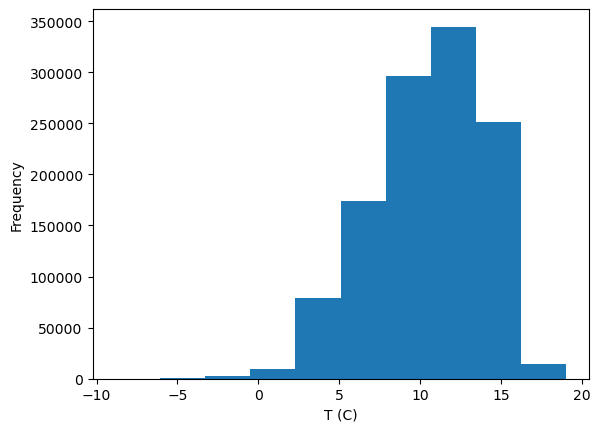

In [280]:
## Verify temp scale
HL_clim_jn.jja.plot.hist()
plt.xlabel('T (C)')

In [309]:
## join in HL ID
HL_clim_jn = pd.concat((HL_clim.reset_index(), gdfHL[['Hylak_id', 'Shp_Area']]), axis=1) # for some reason, just re-assigning column doesn't work

Text(0.5, 1.0, 'HydroLAKES in BAWLD domain')

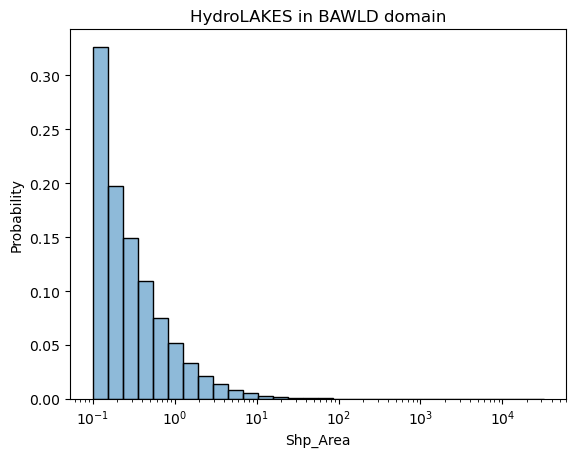

In [338]:
## View distrib of lake areas in HL
# HL_clim_jn.Shp_Area.plot.hist()
sns.histplot(data=HL_clim_jn, x="Shp_Area", element="bars", log_scale=True, bins=30, palette=None, stat='probability', cumulative=False, common_norm=False, fill=True, alpha=0.5) # 
plt.title('HydroLAKES in BAWLD domain')

In [252]:
## Write out x2

joined_clim_dir = os.path.join(analysis_dir, 'joined_climate')
os.makedirs(joined_clim_dir, exist_ok=True)

HL_clim_jn.to_csv(os.path.join(joined_clim_dir, 'HL_clim_full.csv'))
HL_clim_jn[['Hylak_id', 'jja', 'Shp_Area']].to_csv(os.path.join(joined_clim_dir, 'HL_clim_jja.csv'))

In [297]:
## Preview file
!head {os.path.join(joined_clim_dir, 'HL_clim_jja.csv')}

,Hylak_id,jja,Shp_Area
0,2,11.148844401041666,30450.64
1,414668,11.148844401041666,0.2
2,414869,11.148844401041666,0.37
3,415195,11.148844401041666,0.1
4,415250,11.148844401041666,0.15
5,415810,11.148844401041666,0.11
6,415986,11.148844401041666,0.28
7,416165,11.148844401041666,0.12
8,416263,11.148844401041666,0.14


## Apply methane prediction

In [310]:
## Drop duplicates! (Why were these there?...)
HL_clim_jn.drop_duplicates(subset='Hylak_id', inplace=True)

In [330]:
## Flux (areal, gCH4/m2/day)
HL_clim_jn['Est_mg_m2_day'] = 10**(model1.params.Intercept +
    model1.params['np.log10(SA)'] * np.log10(HL_clim_jn.Shp_Area) + model1.params['TEMP'] * HL_clim_jn.ann) # jja, ann, son, mam

## Flux (flux rate, gCH4/day)
HL_clim_jn['Est_g_day'] = HL_clim_jn.Est_mg_m2_day * HL_clim_jn.Shp_Area * 1e3 # (convert km2 -> m2 and mg -> g)

## View
# HL_clim_jn['Est_mg_m2_day'].head()
# HL_clim_jn['Est_g_day'].head()
## Sum! (Tg /yr)

## Sum fluxes and areas
estSum = HL_clim_jn.query('Shp_Area < 5000')['Est_g_day'].sum() * 365.25 / 1e12
print(f'Emissions in BAWLD domain: {estSum:.2} Tg/yr')
print(f"Lake area used: {HL_clim_jn.query('Shp_Area < 5000').Shp_Area.sum():.4} km2")

Emissions in BAWLD domain: 0.18 Tg/yr
Lake area used: 1.025e+06 km2


## TODO:
* apply get_climate function over all hydrolakes using BAWLD cell lat/long X
    * Or, if worldclim netcdf is fine-scale, use individual lake lat/long
* Smart dask way is to define an entire processing chain that ends with writing out
* Apply upscaling calc using lake area (Shp_area) and summer temp X
* If redo-ing, 
    * use lake centroid, and then no need to join to BAWLD (and slightly more nuanced, HR temp data)
    * Apply 'meta' argument to map_partitions to increase speed.
* C or K?
* Plot, sum, profit!

In [70]:
import dbfread

ModuleNotFoundError: No module named 'dbfread'